In [1]:
import tensorflow as tf
tf.enable_eager_execution()

In [2]:
# Tensor is a multi-dimensional array
print(type(tf.add(1,2)))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [3]:
# like a cal
print(tf.add(1,2))

tf.Tensor(3, shape=(), dtype=int32)


In [4]:
print(tf.add([1,7],[3,5]))

tf.Tensor([ 4 12], shape=(2,), dtype=int32)


In [5]:
print(tf.square(6))
# reduce dimension
print(tf.reduce_sum([1,2,4]))

tf.Tensor(36, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)


In [6]:
print(tf.encode_base64("lucky!"))
print(tf.decode_base64(tf.encode_base64("lucky!")))

tf.Tensor(b'bHVja3kh', shape=(), dtype=string)
tf.Tensor(b'lucky!', shape=(), dtype=string)


In [7]:
# Each Tensor has a shape and a datatype
# multiplies matrix
x = tf.matmul([[2]],[[2,3]])
print(x)

tf.Tensor([[4 6]], shape=(1, 2), dtype=int32)


In [8]:
# Differences with Numpy array
# 1. Tensors can be backed by accelerator memory(GPU, TPU)
# 2. Tensors are immutable
# They can be converted directly

import numpy as np
ndarray = np.ones([3,3])
# to tensor
tensor = tf.multiply(ndarray,42)
print(tensor)
# to numpy
print(np.add(tensor,1))
print(tensor.numpy)

tf.Tensor(
[[42. 42. 42.]
 [42. 42. 42.]
 [42. 42. 42.]], shape=(3, 3), dtype=float64)
[[43. 43. 43.]
 [43. 43. 43.]
 [43. 43. 43.]]
<bound method _EagerTensorBase.numpy of <tf.Tensor: id=35, shape=(3, 3), dtype=float64, numpy=
array([[42., 42., 42.],
       [42., 42., 42.],
       [42., 42., 42.]])>>


In [9]:
# GPU acceleration
# automatically decided by tensorflow
x = tf.random_uniform([3, 3])

print("Is there a GPU available: "),
print(tf.test.is_gpu_available())

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

Is there a GPU available: 
False
Is the Tensor on GPU #0:  
False


In [10]:
import time

def time_matmul(x):
    start = time.time()
    for loop in range(10):
        tf.matmul(x,x)
    result = time.time() - start
    print("10 loops: {:0.2f}ms".format(1000*result))

with tf.device("CPU:0"):
    x = tf.random_uniform([1000, 1000])
    assert x.device.endswith("CPU:0")
    time_matmul(x)

10 loops: 125.04ms


In [11]:
# Datasets
# Use tf.data.Dataset to build pipelines to feed data to model
# Creating a Dataset and iteration over a dataset with eager execution enabled.
ds_tensors = tf.data.Dataset.from_tensor_slices([1,2,3,4,5,6])

# Create a CSV file
import tempfile
_, filename = tempfile.mkstemp()

with open(filename,'w') as f:
    f.write("""Line 1
    Line 2
    Line 3""")

ds_file = tf.data.TextLineDataset(filename)

In [12]:
ds_tensors = ds_tensors.map(tf.square).shuffle(2).batch(2)
ds_file = ds_file.batch(2)

In [13]:
print('Elements of ds_tensors:')
for x in ds_tensors:
    print(x)
    
print('\nElements of ds_file:')
for x in ds_file:
    print(x)

Elements of ds_tensors:
Instructions for updating:
Colocations handled automatically by placer.
tf.Tensor([4 1], shape=(2,), dtype=int32)
tf.Tensor([16  9], shape=(2,), dtype=int32)
tf.Tensor([36 25], shape=(2,), dtype=int32)

Elements of ds_file:
tf.Tensor([b'Line 1' b'    Line 2'], shape=(2,), dtype=string)
tf.Tensor([b'    Line 3'], shape=(1,), dtype=string)


In [ ]:
'''
# Automatic differentiation and gradient tape
'''

In [45]:
# Gradient tapes: record
x = tf.ones((2,2))
with tf.GradientTape() as t:
    t.watch(x)
    y = tf.reduce_sum(x)
    z = tf.multiply(y,y)

# input - output
dz_dx = t.gradient(z,x)
for i in [0,1]:
    for j in [0,1]:
        print(dz_dx[i][j])
        assert dz_dx[i][j].numpy() == 8.0
        
# GradientTape.gradient can only be called once on non-persistent tapes.
x = tf.ones((2,2))
with tf.GradientTape() as t:
    t.watch(x)
    y = tf.reduce_sum(x)
    z = tf.multiply(y,y)
# intermediate - output
dz_dy = t.gradient(z,y)
print()
print(dz_dy.numpy(),'\n')

# Use persistent to solve it
x = tf.constant(3.0)
print(x.numpy())
with tf.GradientTape(persistent=True) as t:
    t.watch(x)
    y = x * x
    z = y * y
    print(y.numpy(),z.numpy())

dz_dx = t.gradient(z,x) # diff 4*x^3 -> 108
dy_dx = t.gradient(y,x) # diff 2x -> 6
print(dz_dx,dy_dx)
del t




tf.Tensor(8.0, shape=(), dtype=float32)
tf.Tensor(8.0, shape=(), dtype=float32)
tf.Tensor(8.0, shape=(), dtype=float32)
tf.Tensor(8.0, shape=(), dtype=float32)

8.0 

3.0
9.0 81.0
tf.Tensor(108.0, shape=(), dtype=float32) tf.Tensor(6.0, shape=(), dtype=float32)


In [54]:
# Recording control flow
def f(x,y):
    output = 1.0
    for i in range(y):
        if i > 1 and i < 5:
            output = tf.multiply(output,x)
    return output
    

def grad(x,y):
    with tf.GradientTape() as t:
        t.watch(x)
        out = f(x,y)
    return t.gradient(out,x)

x = tf.convert_to_tensor(2.0)


print(grad(x,6).numpy())

12.0


In [57]:
x = tf.Variable(1.0)

# High order gradient, gradient of gradient
with tf.GradientTape() as t:
    with tf.GradientTape() as t2:
        y = x * x * x
        dy_dx = t2.gradient(y,x)
    dy_dx2 = t.gradient(dy_dx,x)

assert dy_dx.numpy() == 3.0
assert dy_dx2.numpy() == 6.0

In [58]:
'''
# Custom training
'''

x = tf.zeros([10,10])
x += 2
print(x)

tf.Tensor(
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], shape=(10, 10), dtype=float32)


In [66]:
v = tf.Variable(1.0)
assert v.numpy() == 1

v.assign(3)
assert v.numpy() == 3.0

v.assign(tf.sqrt(v))

print(v.numpy(),np.sqrt(3.0))


1.7320508 1.7320508075688772


In [67]:
class Model(object):
    def __init__(self):
        self.W = tf.Variable(5.0)
        self.b = tf.Variable(0.0)
        
    def __call__(self,x):
        return self.W * x + self.b

model = Model()
print(model(3.0).numpy())

15.0


In [68]:
def loss(predicted_y,desired_y):
    return tf.reduce_mean(tf.square(predicted_y-desired_y))

In [69]:
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs  = tf.random_normal(shape=[NUM_EXAMPLES])
noise   = tf.random_normal(shape=[NUM_EXAMPLES])
outputs = inputs * TRUE_W + TRUE_b + noise

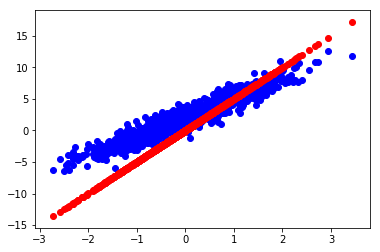

In [71]:
import matplotlib.pyplot as plt
plt.scatter(inputs, outputs, c = 'b')
plt.scatter(inputs,model(inputs),c='r')
plt.show()

In [72]:
print('loss:',loss(model(inputs),outputs).numpy() )

loss: 9.270989


In [76]:
# Defining a training loop
def train(model,inputs,outputs,learning_rate):
    with tf.GradientTape() as t:
        current_loss = loss(model(inputs),outputs)
    dW, db = t.gradient(current_loss,[model.W,model.b])
    model.W.assign_sub(learning_rate*dW)
    model.b.assign_sub(learning_rate*db)

Epoch  0: W=5.00 b=0.00, loss=9.27099
Epoch  1: W=3.77 b=1.22, loss=2.29082
Epoch  2: W=3.29 b=1.70, loss=1.21987
Epoch  3: W=3.11 b=1.90, loss=1.05545
Epoch  4: W=3.03 b=1.97, loss=1.03018
Epoch  5: W=3.01 b=2.00, loss=1.02630
Epoch  6: W=3.00 b=2.01, loss=1.02570
Epoch  7: W=2.99 b=2.02, loss=1.02561
Epoch  8: W=2.99 b=2.02, loss=1.02560
Epoch  9: W=2.99 b=2.02, loss=1.02560


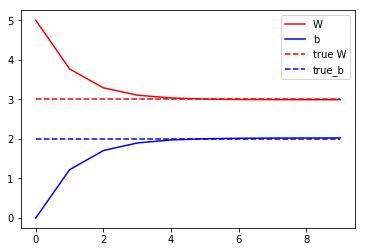

In [82]:
model = Model()
Ws,bs = [],[]
epochs = range(10)
for epoch in epochs:
    Ws.append(model.W.numpy())
    bs.append(model.b.numpy())
    current_loss = loss(model(inputs),outputs)
    train(model,inputs,outputs,learning_rate = .3)
    print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' % (epoch, Ws[-1], bs[-1], current_loss))

plt.plot(epochs,Ws,'r',epochs,bs,'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
         [TRUE_b] * len(epochs), 'b--')
plt.legend(['W', 'b', 'true W', 'true_b'])
plt.show()
